In [58]:
!pip install fredapi

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from fredapi import Fred

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble      import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics       import (
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix
)

from imblearn.over_sampling import SMOTE
from lightgbm               import LGBMClassifier

In [60]:
api = 'bb85abbab401b0f66c22e8fad2002cb1'

In [61]:
fred = Fred(api_key=api)

start = datetime.datetime(1950, 1, 1)
end = datetime.datetime(2025, 1, 1)

In [62]:
# Fetch some key series from FRED
fred_series = {
    't10y2y': 'T10Y2Y',                             # 10y - 2y Treasury spread
    't10y3m': 'T10Y3M',                             # 10y - 3m Treasury spread
    'unemployment_rate': 'UNRATE',                  # Unemployment rate
    'initial_jobless_claims': 'ICSA',               # Weekly initial claims
    'labor_force_participation_rate': 'CIVPART',    # Labor force participation
    'retail_sales': 'RSAFS',                        # Retail sales
    'industrial_production_index': 'INDPRO',        # Industrial production index
    'cpi_yoy': 'CPIAUCNS',                          # CPI (YoY)
    'housing_starts': 'HOUST',                      # Housing starts
    'building_permits': 'PERMIT',                   # Building permits
    'leading_economic_index': 'USSLIND',            # Conference Board Leading Economic Index
    'nber_recession_indicator': 'USREC',             # NBER recession indicator
    'recession_probability': 'RECPROUSM156N'       # Smoothed recession probability
}

In [63]:
series_q = []

for nice, code in fred_series.items():
    print(f"Fetching {nice} ({code})…")
    try:
        s = fred.get_series(code)

        # Resample quarterly
        if nice == "nber_recession_indicator":
            s_q = s.resample("QE").max()  # If any month in quarter is a recession, mark the quarter as recession
        else:
            s_q = s.resample("QE").last()  # Use last observation of quarter for most economic indicators

        s_q.name = nice
        series_q.append(s_q)

    except Exception as e:
        print(f"Warning: Could not fetch {nice} ({code}) — {e}")

print("\nDone fetching!")

# Merge all series side-by-side into single DataFrame
data = pd.concat(series_q, axis=1)
# Restrict to desired time window and forward-fill missing data
data = data.loc[start:end].ffill()

# Define recession variable names
recession_vars = ['nber_recession_indicator', 'recession_probability']

# Create target dataset
y = data[recession_vars]

# Create predictor dataset (drop the target variables)
X = data.drop(columns=recession_vars)

print("\nPredictors (X):", X.columns.tolist())
print("\nTargets (y):", y.columns.tolist())

Fetching t10y2y (T10Y2Y)…
Fetching t10y3m (T10Y3M)…
Fetching unemployment_rate (UNRATE)…
Fetching initial_jobless_claims (ICSA)…
Fetching labor_force_participation_rate (CIVPART)…
Fetching retail_sales (RSAFS)…
Fetching industrial_production_index (INDPRO)…
Fetching cpi_yoy (CPIAUCNS)…
Fetching housing_starts (HOUST)…
Fetching building_permits (PERMIT)…
Fetching leading_economic_index (USSLIND)…
Fetching nber_recession_indicator (USREC)…
Fetching recession_probability (RECPROUSM156N)…

Done fetching!

Predictors (X): ['t10y2y', 't10y3m', 'unemployment_rate', 'initial_jobless_claims', 'labor_force_participation_rate', 'retail_sales', 'industrial_production_index', 'cpi_yoy', 'housing_starts', 'building_permits', 'leading_economic_index']

Targets (y): ['nber_recession_indicator', 'recession_probability']


In [64]:
X.head()

,t10y2y,t10y3m,unemployment_rate,initial_jobless_claims,labor_force_participation_rate,retail_sales,industrial_production_index,cpi_yoy,housing_starts,building_permits,leading_economic_index
1950-03-31,NaN,NaN,6.3,NaN,58.8,NaN,14.5156,23.6,NaN,NaN,NaN
1950-06-30,NaN,NaN,5.4,NaN,59.4,NaN,15.8059,23.8,NaN,NaN,NaN
1950-09-30,NaN,NaN,4.4,NaN,59.2,NaN,16.7198,24.4,NaN,NaN,NaN
1950-12-31,NaN,NaN,4.3,NaN,59.2,NaN,17.0962,25.0,NaN,NaN,NaN
1951-03-31,NaN,NaN,3.4,NaN,59.8,NaN,17.3381,25.8,NaN,NaN,NaN


In [65]:
X.tail()

,t10y2y,t10y3m,unemployment_rate,initial_jobless_claims,labor_force_participation_rate,retail_sales,industrial_production_index,cpi_yoy,housing_starts,building_permits,leading_economic_index
2023-12-31,-0.35,-1.52,3.8,198000.0,62.5,686277.0,102.6309,306.746,1568.0,1530.0,1.72
2024-03-31,-0.39,-1.26,3.9,223000.0,62.7,688248.0,102.5186,312.332,1299.0,1485.0,1.72
2024-06-30,-0.35,-1.12,4.1,238000.0,62.6,690682.0,103.2534,314.175,1329.0,1454.0,1.72
2024-09-30,0.15,-0.92,4.1,227000.0,62.7,703079.0,102.5954,315.301,1355.0,1425.0,1.72
2024-12-31,0.33,0.21,4.1,209000.0,62.5,717662.0,103.1177,315.605,1526.0,1482.0,1.72


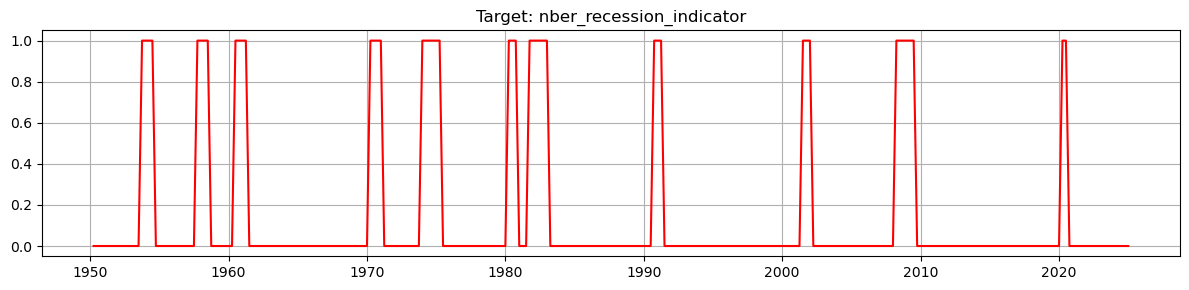

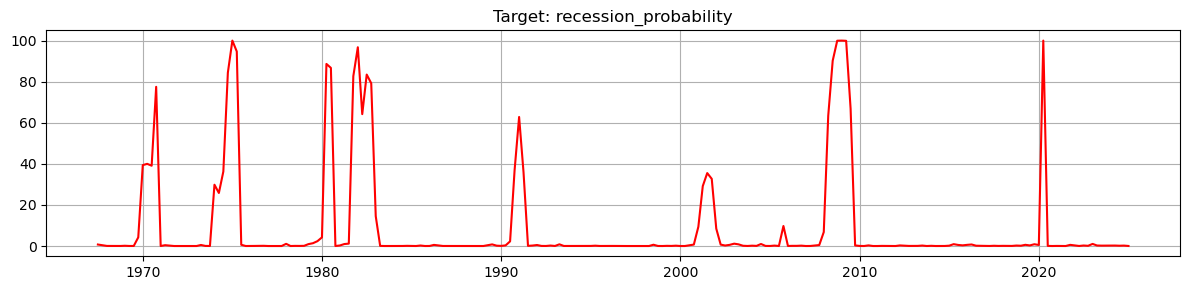

In [66]:
# 1. Plot target variables (in red) and save each with a unique filename
for col in y.columns:
    plt.figure(figsize=(12, 3))
    plt.plot(y.index, y[col], color='red')
    plt.title(f"Target: {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"target_{col}.png", dpi=600, bbox_inches='tight')
    plt.show()

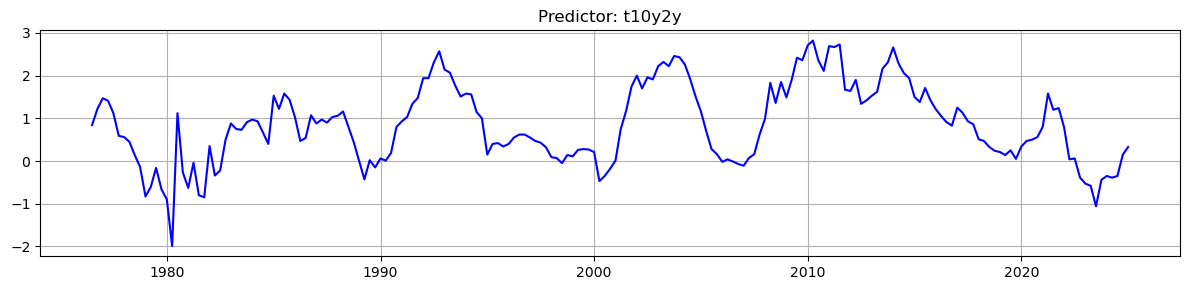

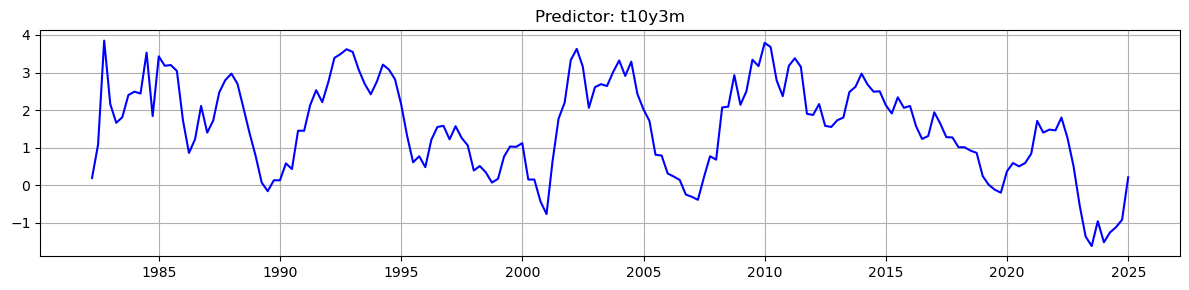

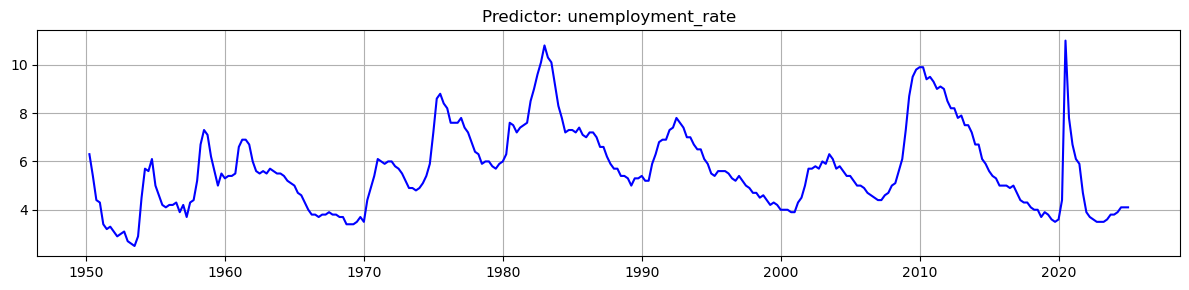

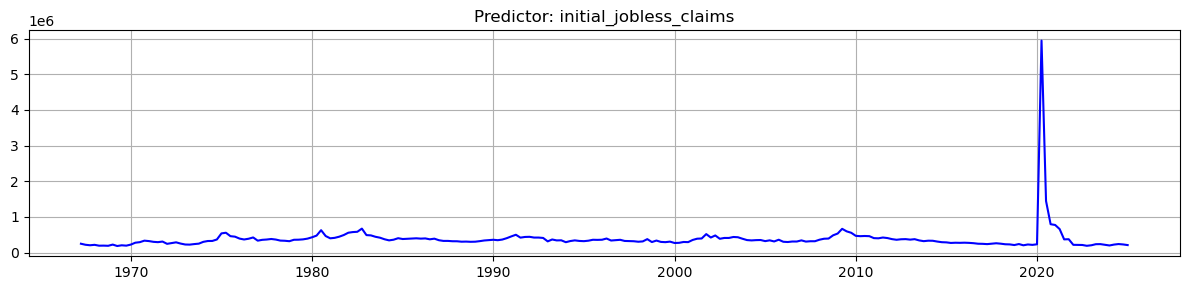

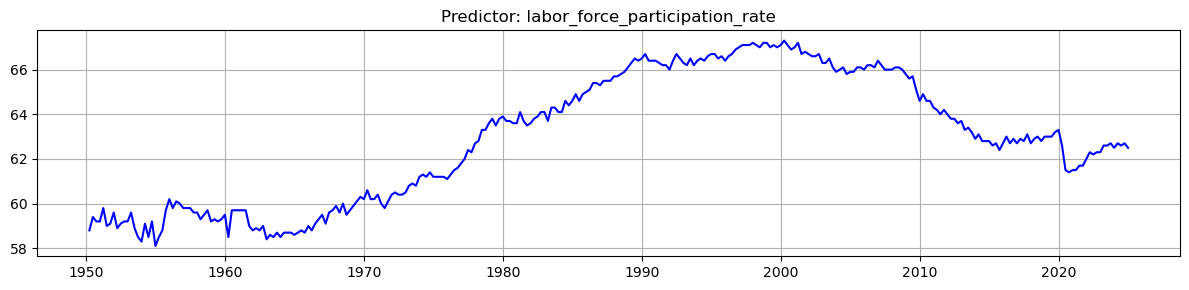

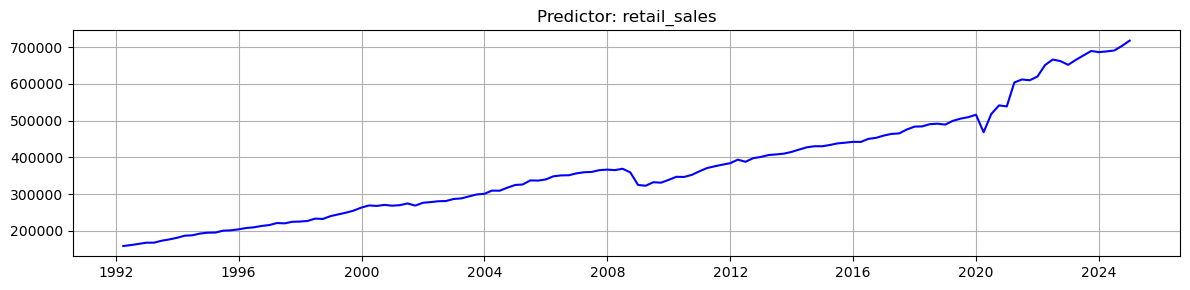

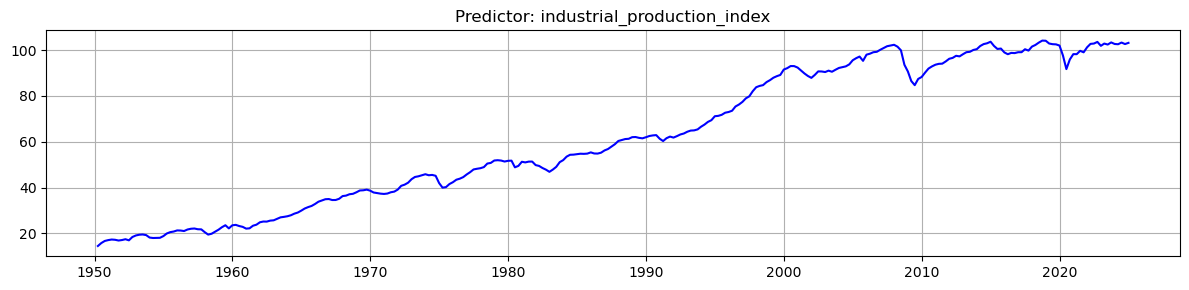

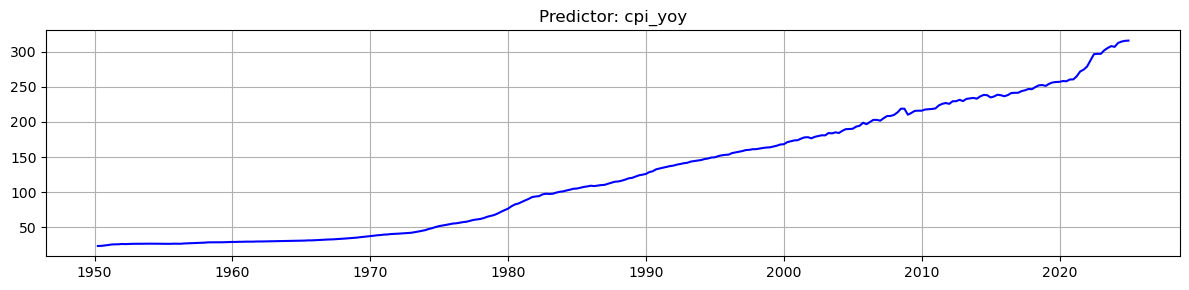

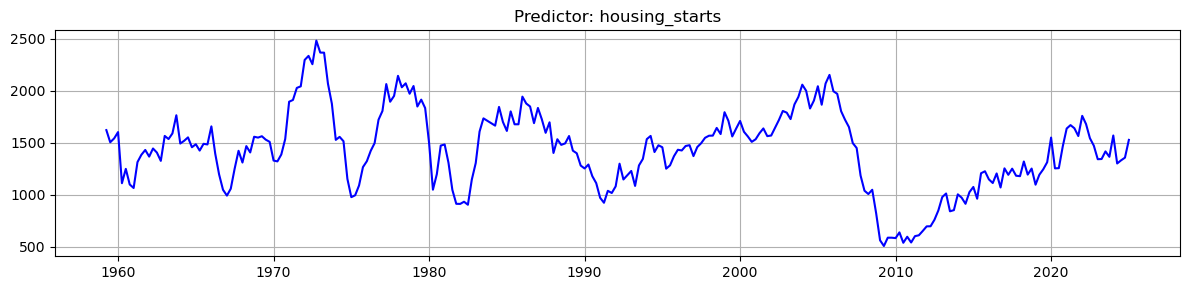

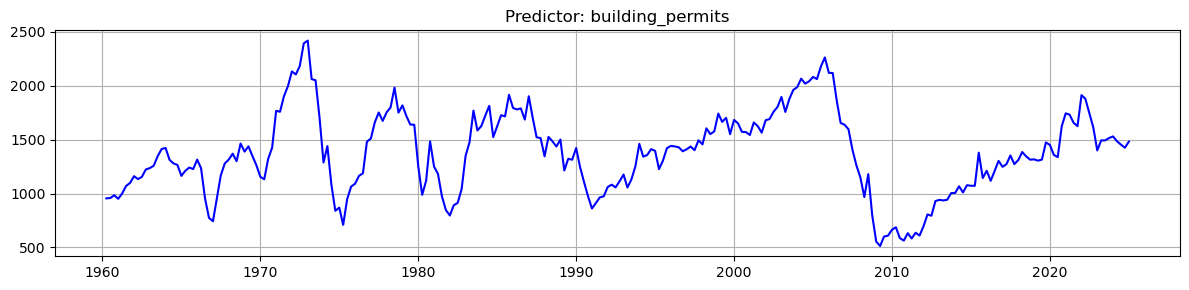

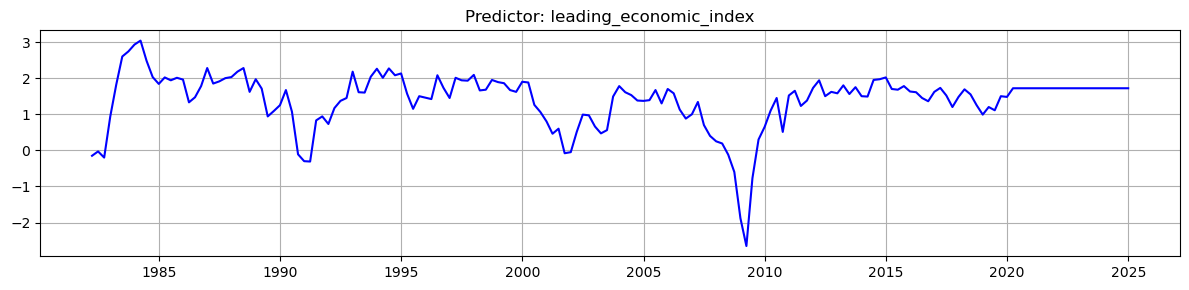

In [67]:
# 2. Plot predictor variables (in blue) and save each with a unique filename
for col in X.columns:
    plt.figure(figsize=(12, 3))
    plt.plot(X.index, X[col], color='blue')
    plt.title(f"Predictor: {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"predictor_{col}.png", dpi=600, bbox_inches='tight')
    plt.show()

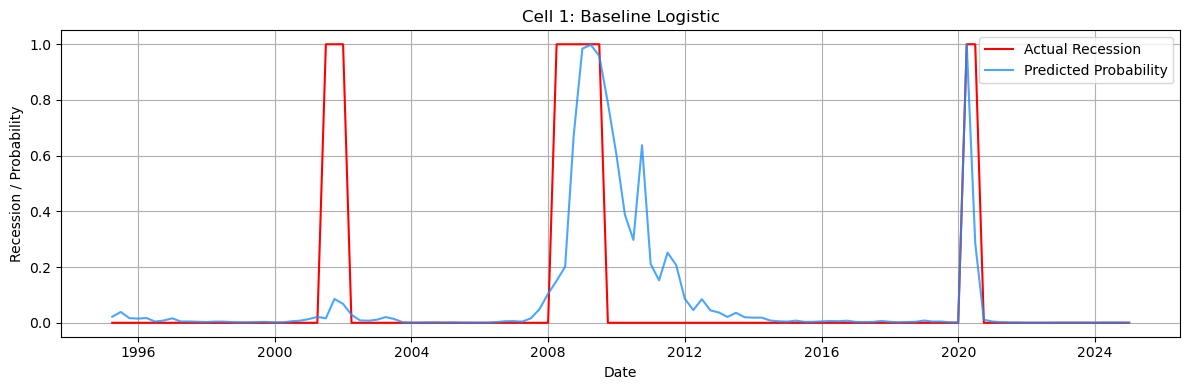

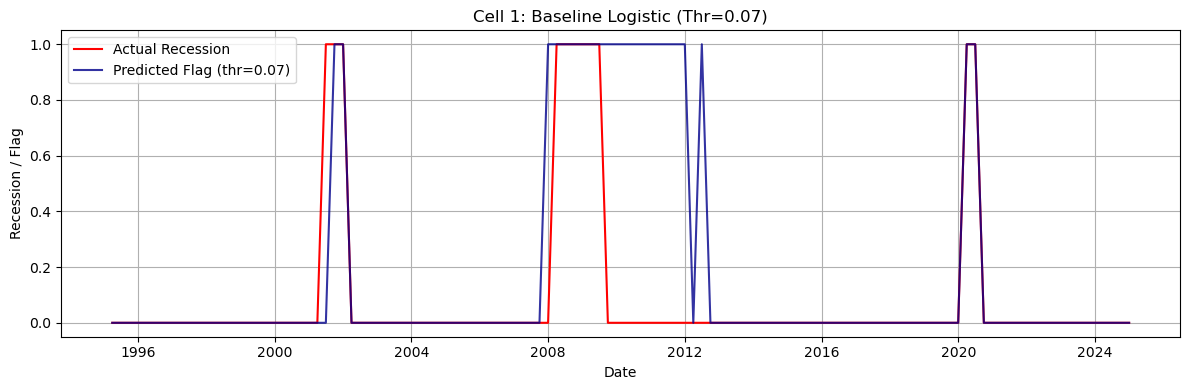

In [68]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 1: Baseline logistic regression on raw predictors
#   • No AR lags or %-change features
#   • 60/40 chronological split
#   • Threshold optimized via precision–recall curve
# ──────────────────────────────────────────────────────────────────────────────

# 1) Prepare data
X_filled = X.ffill().bfill()
y_filled = y['nber_recession_indicator'].ffill().bfill()

# 2) Standardize predictors
scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X_filled)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# 3) Chronological train/validation split (60/40)
n         = len(X_scaled_df)
train_end = int(n * 0.6)
X_train   = X_scaled_df.iloc[:train_end]
y_train   = y_filled.iloc[:train_end]
X_val     = X_scaled_df.iloc[train_end:]
y_val     = y_filled.iloc[train_end:]

# 4) Train model & get probabilities
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
probs = model.predict_proba(X_val)[:, 1]

# 5) Optimize threshold via precision–recall curve
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores     = 2 * (prec * rec) / (prec + rec)
best_idx      = np.nanargmax(f1_scores)
best_thresh   = th[best_idx]

# 6) Binarize with optimized threshold
flags = (probs >= best_thresh).astype(int)

# 7) Plots
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,   color='red', label='Actual Recession')
plt.plot(y_val.index, probs,   color='dodgerblue',  alpha=0.8, label='Predicted Probability')
plt.title("Cell 1: Baseline Logistic")
plt.ylabel("Recession / Probability")
plt.xlabel("Date")
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.savefig("Cell 1- Baseline Logistic.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,    color='red', label='Actual Recession')
plt.plot(y_val.index, flags,    color='darkblue', alpha=0.8, label=f'Predicted Flag (thr={best_thresh:.2f})')
plt.title(f"Cell 1: Baseline Logistic (Thr={best_thresh:.2f})")
plt.ylabel("Recession / Flag")
plt.xlabel("Date")
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.savefig(f"Cell 1- Baseline Logistic (Thr={best_thresh:.2f}).png", dpi=600, bbox_inches='tight')
plt.show()

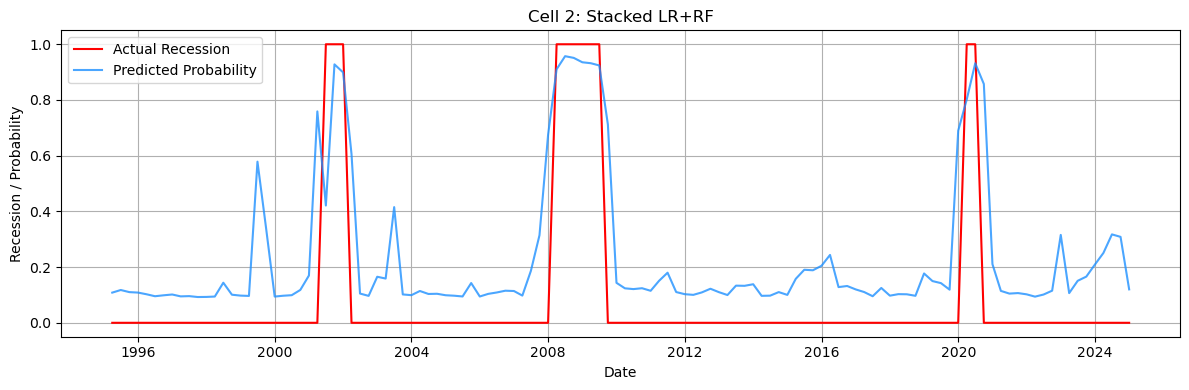

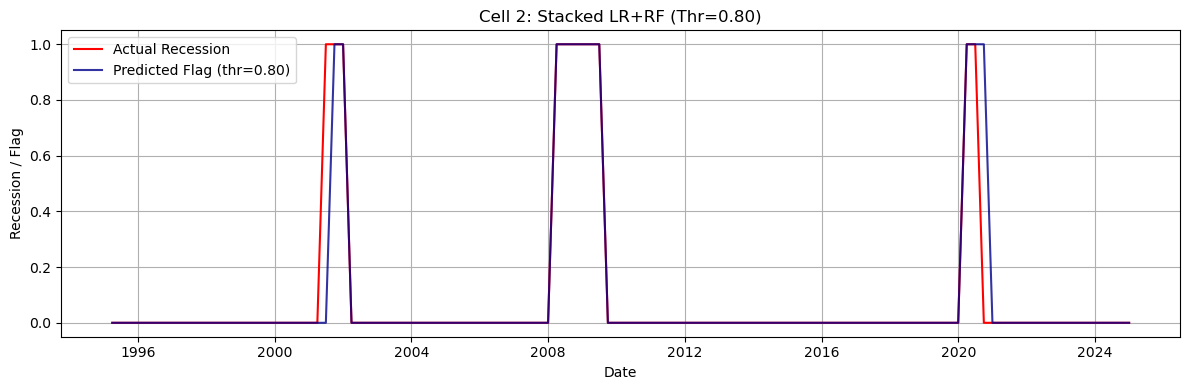

In [69]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 2: Stacked logistic + Random Forest
#   • Adds AR(1–3) lags + %-change features
#   • L1-regularized logistic tuned via time-series CV
#   • Stacked with a shallow RF (5-fold CV)
#   • 60/40 split, threshold optimized via precision–recall curve
# ──────────────────────────────────────────────────────────────────────────────

# 1) Prepare & feature-engineer
X_filled = X.ffill().bfill()
y_filled = y['nber_recession_indicator'].ffill().bfill()

for lag in (1, 2, 3):
    X_filled[f'recession_lag{lag}'] = y_filled.shift(lag)
for col in X.columns:
    X_filled[f'{col}_pctchg1'] = X_filled[col].pct_change(1)
    X_filled[f'{col}_pctchg3'] = X_filled[col].pct_change(3)

X_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_filled = X_filled.ffill().bfill()

# 2) Scale predictors
scaler      = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_filled),
    index=X_filled.index,
    columns=X_filled.columns
)

# 3) Chronological split (60/40)
n         = len(X_scaled_df)
train_end = int(n * 0.6)
X_train   = X_scaled_df.iloc[:train_end]
y_train   = y_filled.iloc[:train_end]
X_val     = X_scaled_df.iloc[train_end:]
y_val     = y_filled.iloc[train_end:]

# 4) L1-logistic grid search (time-series CV)
tscv      = TimeSeriesSplit(n_splits=5)
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1'], 'solver': ['liblinear']}
grid      = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1
)
grid.fit(X_train, y_train)
best_lr   = grid.best_estimator_

# 5) Build stacking classifier
base_rf = RandomForestClassifier(
    n_estimators=200, max_depth=5,
    class_weight='balanced_subsample', random_state=42
)
stack   = StackingClassifier(
    estimators=[('lr', best_lr), ('rf', base_rf)],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=5, n_jobs=-1
)
stack.fit(X_train, y_train)

# 6) Predict probabilities
probs = stack.predict_proba(X_val)[:, 1]

# 7) Optimize threshold via precision–recall
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores     = 2 * (prec * rec) / (prec + rec)
best_thresh   = th[np.nanargmax(f1_scores)]

# 8) Binarize with optimized threshold
flags = (probs >= best_thresh).astype(int)

# 9) Plots
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,   color='red', label='Actual Recession')
plt.plot(y_val.index, probs,   color='dodgerblue',  alpha=0.8, label='Predicted Probability')
plt.title("Cell 2: Stacked LR+RF")
plt.ylabel("Recession / Probability")
plt.xlabel("Date")
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.savefig("Cell 2- Stacked LR+RF.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,    color='red', label='Actual Recession')
plt.plot(y_val.index, flags,    color='darkblue', alpha=0.8, label=f'Predicted Flag (thr={best_thresh:.2f})')
plt.title(f"Cell 2: Stacked LR+RF (Thr={best_thresh:.2f})")
plt.ylabel("Recession / Flag")
plt.xlabel("Date")
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.savefig(f"Cell 2- Stacked LR+RF (Thr={best_thresh:.2f}).png", dpi=600, bbox_inches='tight')
plt.show()

[LightGBM] [Info] Number of positive: 146, number of negative: 146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 292, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

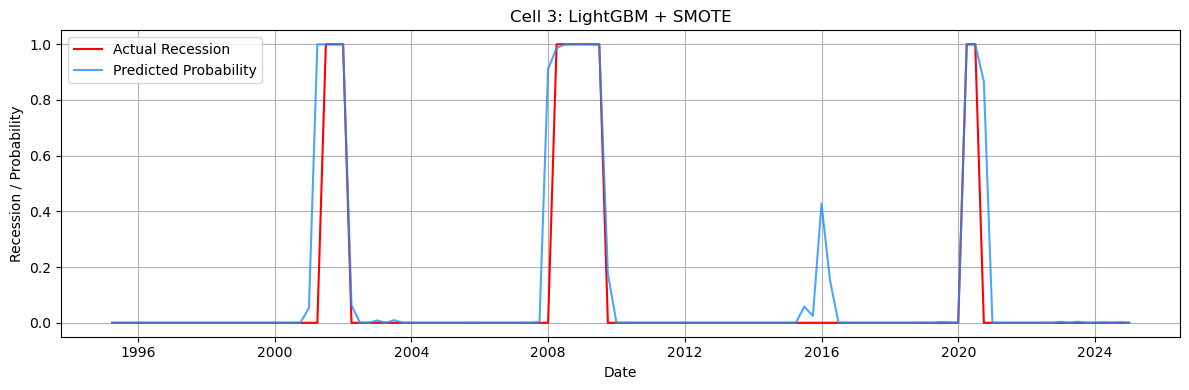

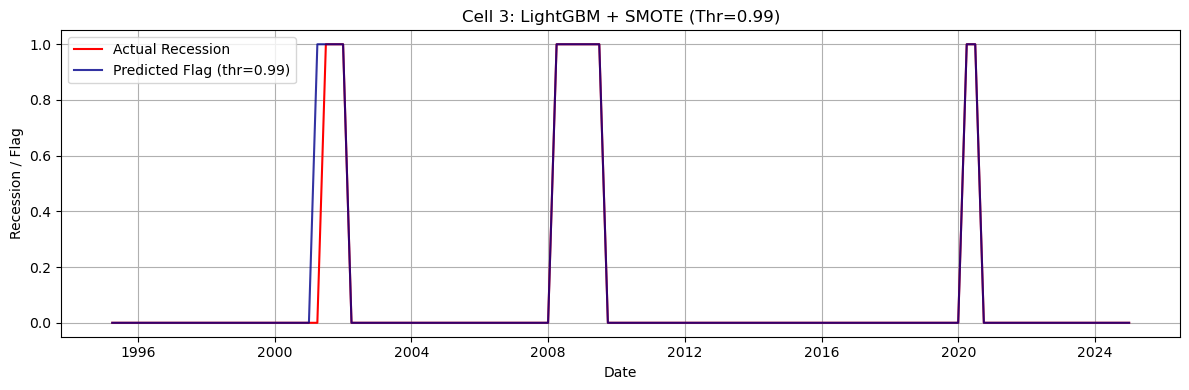

In [70]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 3: LightGBM with SMOTE oversampling
#   • Same AR(1–3) & %-change features as Cell 2
#   • Balances training set with SMOTE
#   • LightGBM tuned via time-series CV
#   • 60/40 split, threshold optimized via PR‐curve, and plots only
# ──────────────────────────────────────────────────────────────────────────────

# 1) Prepare & feature-engineer
X_filled = X.ffill().bfill()
y_filled = y['nber_recession_indicator'].ffill().bfill()

for lag in (1, 2, 3):
    X_filled[f'recession_lag{lag}'] = y_filled.shift(lag)
for col in X.columns:
    X_filled[f'{col}_pctchg1'] = X_filled[col].pct_change(1)
    X_filled[f'{col}_pctchg3'] = X_filled[col].pct_change(3)

X_filled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_filled = X_filled.ffill().bfill()

# 2) Scale & split (60/40)
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_filled),
    index=X_filled.index,
    columns=X_filled.columns
)
n = len(X_scaled_df)
train_end = int(n * 0.6)
X_train, X_val = X_scaled_df.iloc[:train_end], X_scaled_df.iloc[train_end:]
y_train, y_val = y_filled.iloc[:train_end],    y_filled.iloc[train_end:]

# 3) SMOTE on the training set
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# 4) LightGBM grid search (time-series CV)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators':     [100, 300],
    'num_leaves':       [15, 31],
    'max_depth':        [4, 6, -1],
    'learning_rate':    [0.01, 0.05],
    'subsample':        [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
grid = GridSearchCV(
    LGBMClassifier(random_state=42),
    param_grid, cv=tscv, scoring='f1', n_jobs=-1
)
grid.fit(X_res, y_res)
best_lgbm = grid.best_estimator_

# 5) Predict probabilities
probs = best_lgbm.predict_proba(X_val)[:, 1]

# 6) Optimize threshold via precision–recall curve
prec, rec, th = precision_recall_curve(y_val, probs)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_thresh = th[np.nanargmax(f1_scores)]

# 7) Binarize using optimized threshold
flags = (probs >= best_thresh).astype(int)

# 8) Plots
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,    color='red', label='Actual Recession')
plt.plot(y_val.index, probs,    color='dodgerblue',  alpha=0.8, label='Predicted Probability')
plt.title("Cell 3: LightGBM + SMOTE")
plt.ylabel("Recession / Probability")
plt.xlabel("Date")
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.savefig("Cell 3- LightGBM + SMOTE.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val,     color='red', label='Actual Recession')
plt.plot(y_val.index, flags,     color='darkblue', alpha=0.8, label=f'Predicted Flag (thr={best_thresh:.2f})')
plt.title(f"Cell 3: LightGBM + SMOTE (Thr={best_thresh:.2f})")
plt.ylabel("Recession / Flag")
plt.xlabel("Date")
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.savefig(f"Cell 3- LightGBM + SMOTE (Thr={best_thresh:.2f}).png", dpi=600, bbox_inches='tight')
plt.show()

In [71]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 4: Comparative metrics table for three models
#
# Legend:
#  - Any metric column ending with “↑” means higher is better.
#  - “Best Threshold” is the probability cutoff that maximizes F₁ on the validation set.
# ──────────────────────────────────────────────────────────────────────────────

results = []

# 1) Baseline Logistic Regression (original features only)
orig_feats   = X.columns.tolist()
X_val_base   = X_scaled_df[orig_feats].iloc[train_end:]
probs_lr     = model.predict_proba(X_val_base)[:, 1]
roc_lr       = roc_auc_score(y_val, probs_lr)
ap_lr        = average_precision_score(y_val, probs_lr)
prec_lr, rec_lr, th_lr = precision_recall_curve(y_val, probs_lr)
f1_lr        = 2 * prec_lr * rec_lr / (prec_lr + rec_lr)
ix_lr        = np.nanargmax(f1_lr)

results.append({
    'Model':             'Baseline LR',
    'ROC AUC ↑':         roc_lr,
    'Precision ↑':       prec_lr[ix_lr],
    'Recall ↑':          rec_lr[ix_lr],
    'Best Threshold':    th_lr[ix_lr],
    'F1 ↑':              f1_lr[ix_lr],
    'Avg Precision ↑':   ap_lr
})

# 2) Stacked Logistic + RF Ensemble
probs_s = stack.predict_proba(X_val)[:, 1]
roc_s   = roc_auc_score(y_val, probs_s)
ap_s    = average_precision_score(y_val, probs_s)
prec_s, rec_s, th_s = precision_recall_curve(y_val, probs_s)
f1_s    = 2 * prec_s * rec_s / (prec_s + rec_s)
ix_s    = np.nanargmax(f1_s)

results.append({
    'Model':             'LR + RF Ensemble',
    'ROC AUC ↑':         roc_s,
    'Precision ↑':       prec_s[ix_s],
    'Recall ↑':          rec_s[ix_s],
    'Best Threshold':    th_s[ix_s],
    'F1 ↑':              f1_s[ix_s],
    'Avg Precision ↑':   ap_s
})

# 3) LightGBM with SMOTE
probs_l = best_lgbm.predict_proba(X_val)[:, 1]
roc_l   = roc_auc_score(y_val, probs_l)
ap_l    = average_precision_score(y_val, probs_l)
prec_l, rec_l, th_l = precision_recall_curve(y_val, probs_l)
f1_l    = 2 * prec_l * rec_l / (prec_l + rec_l)
ix_l    = np.nanargmax(f1_l)

results.append({
    'Model':             'LightGBM + SMOTE',
    'ROC AUC ↑':         roc_l,
    'Precision ↑':       prec_l[ix_l],
    'Recall ↑':          rec_l[ix_l],
    'Best Threshold':    th_l[ix_l],
    'F1 ↑':              f1_l[ix_l],
    'Avg Precision ↑':   ap_l
})

# Build and display the comparison table
df_compare = pd.DataFrame(results).set_index('Model')
display(df_compare)

,ROC AUC ↑,Precision ↑,Recall ↑,Best Threshold,F1 ↑,Avg Precision ↑
Model,,,,,,
Baseline LR,0.937448,0.454545,0.909091,0.067763,0.606061,0.681417
LR + RF Ensemble,0.993328,0.909091,0.909091,0.801381,0.909091,0.956382
LightGBM + SMOTE,0.996664,0.916667,1.000000,0.986502,0.956522,0.964968
